In [1]:
# Import Required Libraries
import os
import shutil
import pathlib

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
# !unzip -qq archive.zip

2023-12-20 05:49:30.725646: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 05:49:30.728049: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 05:49:30.775139: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 05:49:30.775912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 05:49:31.540608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Check Tensorflow Version
import tensorflow
tensorflow.__version__

'2.13.1'

In [3]:
# Uncomment if the training, validation and test datasets haven't been created yet
#!unzip -qq archive.zip

In [4]:
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO

IMG_PATH = "./"

# split the data by train/val/test
# ignored = {"pred","Br35H-Mask-RCNN"}
accepted = {"no", "yes"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS in accepted:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 0.20*IMG_NUM:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.80*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists


In [5]:
# Set up paths to training, validation and test data
train_dir = './TRAIN'
val_dir = './VAL'
test_dir = './TEST'

In [6]:
# Initialize Model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2023-12-20 05:49:33.612620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 05:49:33.649296: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Compile Model
model.compile(loss='binary_crossentropy',\
             optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

In [8]:
# Initialize ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Training Data Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    shuffle=True,
                                                    class_mode='binary')

Found 1800 images belonging to 2 classes.


In [10]:
# Validation Data Generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        shuffle=True,
                                                        class_mode='binary')

Found 600 images belonging to 2 classes.


In [11]:
# Test Data Generator
test_generator = val_datagen.flow_from_directory(test_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        shuffle=True,
                                                        class_mode='binary')

Found 600 images belonging to 2 classes.


In [12]:
# Inspect Data & Labels Batch Shape
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [13]:
# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_original_data.tf",
        save_best_only=True,
        monitor="val_loss",
        save_format="tf")
]
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/30
90/90 [==============================] - ETA: 0s - loss: 0.5212 - acc: 0.7422INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 9s 94ms/step - loss: 0.5212 - acc: 0.7422 - val_loss: 0.4363 - val_acc: 0.8017
Epoch 2/30
90/90 [==============================] - ETA: 0s - loss: 0.3918 - acc: 0.8356INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 91ms/step - loss: 0.3918 - acc: 0.8356 - val_loss: 0.3601 - val_acc: 0.8317
Epoch 3/30
90/90 [==============================] - ETA: 0s - loss: 0.3102 - acc: 0.8722INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 93ms/step - loss: 0.3102 - acc: 0.8722 - val_loss: 0.3019 - val_acc: 0.8633
Epoch 4/30
90/90 [==============================] - ETA: 0s - loss: 0.2401 - acc: 0.9128INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 91ms/step - loss: 0.2401 - acc: 0.9128 - val_loss: 0.2452 - val_acc: 0.9033
Epoch 5/30
90/90 [==============================] - 8s 85ms/step - loss: 0.1939 - acc: 0.9361 - val_loss: 0.2586 - val_acc: 0.8950
Epoch 6/30
90/90 [==============================] - ETA: 0s - loss: 0.1487 - acc: 0.9561INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.1487 - acc: 0.9561 - val_loss: 0.2167 - val_acc: 0.9250
Epoch 7/30
90/90 [==============================] - ETA: 0s - loss: 0.1107 - acc: 0.9744INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.1107 - acc: 0.9744 - val_loss: 0.1606 - val_acc: 0.9533
Epoch 8/30
90/90 [==============================] - ETA: 0s - loss: 0.0913 - acc: 0.9778INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0913 - acc: 0.9778 - val_loss: 0.1389 - val_acc: 0.9633
Epoch 9/30
90/90 [==============================] - ETA: 0s - loss: 0.0687 - acc: 0.9861INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0687 - acc: 0.9861 - val_loss: 0.1378 - val_acc: 0.9500
Epoch 10/30
90/90 [==============================] - 8s 83ms/step - loss: 0.0860 - acc: 0.9772 - val_loss: 0.1396 - val_acc: 0.9550
Epoch 11/30
90/90 [==============================] - ETA: 0s - loss: 0.0472 - acc: 0.9922INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0472 - acc: 0.9922 - val_loss: 0.1164 - val_acc: 0.9617
Epoch 12/30
90/90 [==============================] - 8s 83ms/step - loss: 0.0366 - acc: 0.9950 - val_loss: 0.1281 - val_acc: 0.9583
Epoch 13/30
90/90 [==============================] - 7s 83ms/step - loss: 0.0325 - acc: 0.9967 - val_loss: 0.1259 - val_acc: 0.9533
Epoch 14/30
90/90 [==============================] - ETA: 0s - loss: 0.0242 - acc: 0.9972INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0242 - acc: 0.9972 - val_loss: 0.1151 - val_acc: 0.9667
Epoch 15/30
90/90 [==============================] - 8s 84ms/step - loss: 0.0212 - acc: 0.9989 - val_loss: 0.1267 - val_acc: 0.9533
Epoch 16/30
90/90 [==============================] - ETA: 0s - loss: 0.0191 - acc: 0.9983INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0191 - acc: 0.9983 - val_loss: 0.1129 - val_acc: 0.9683
Epoch 17/30
90/90 [==============================] - 8s 83ms/step - loss: 0.0162 - acc: 0.9989 - val_loss: 0.1143 - val_acc: 0.9617
Epoch 18/30
90/90 [==============================] - ETA: 0s - loss: 0.0136 - acc: 0.9994INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0136 - acc: 0.9994 - val_loss: 0.1125 - val_acc: 0.9600
Epoch 19/30
90/90 [==============================] - 8s 83ms/step - loss: 0.0109 - acc: 0.9994 - val_loss: 0.1143 - val_acc: 0.9600
Epoch 20/30
90/90 [==============================] - 8s 83ms/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.1269 - val_acc: 0.9567
Epoch 21/30
90/90 [==============================] - 7s 82ms/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.1188 - val_acc: 0.9583
Epoch 22/30
90/90 [==============================] - ETA: 0s - loss: 0.0074 - acc: 1.0000INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 92ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.1105 - val_acc: 0.9683
Epoch 23/30
90/90 [==============================] - ETA: 0s - loss: 0.0070 - acc: 1.0000INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 8s 90ms/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.1078 - val_acc: 0.9667
Epoch 24/30
90/90 [==============================] - 8s 85ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.1232 - val_acc: 0.9583
Epoch 25/30
90/90 [==============================] - 7s 83ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.1218 - val_acc: 0.9583
Epoch 26/30
90/90 [==============================] - 8s 83ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.1235 - val_acc: 0.9583
Epoch 27/30
90/90 [==============================] - 7s 83ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.1129 - val_acc: 0.9683
Epoch 28/30
90/90 [==============================] - 8s 83ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.1234 - val_acc: 0.9600
Epoch 29/30
90/90 [==============================] - 7s 83ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.1226 - val_acc: 0.9600
Epoch 30/30
90/90 [==============================] - 7s 83ms/step - loss: 0.0037 - acc: 

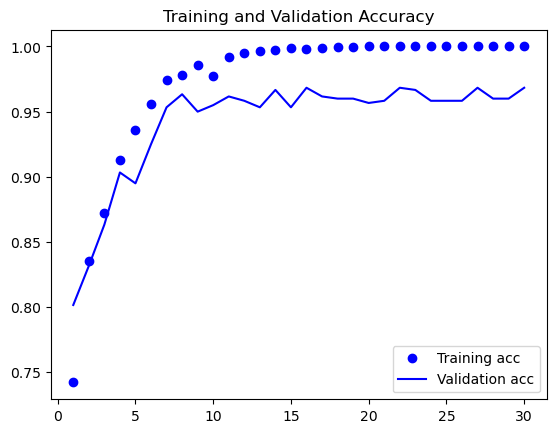

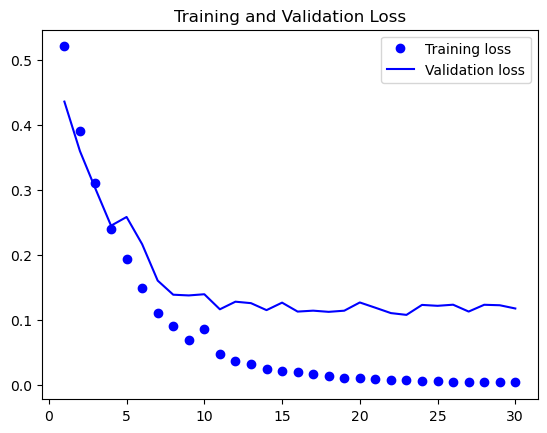

In [14]:
# Plot loss and accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [15]:
# Compute Median Training Accuracy
acc_median = np.median(acc)
acc_median

0.9986111223697662

In [16]:
# Initialize Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.3, 1.0),
    horizontal_flip=True, 
    vertical_flip=True,     
    fill_mode='nearest')

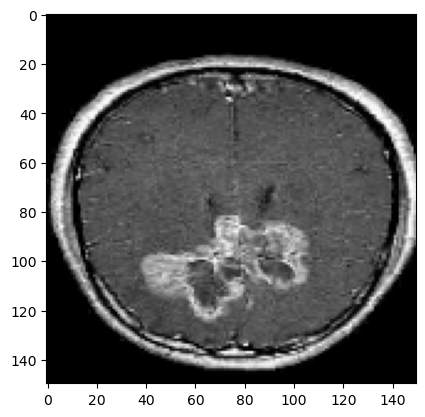

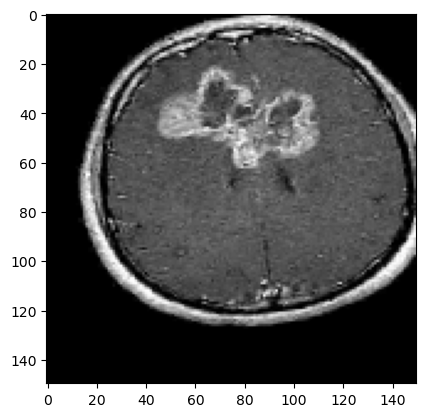

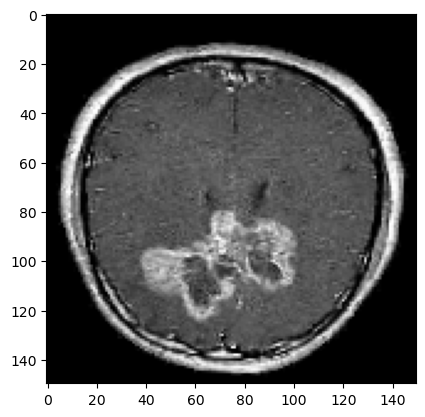

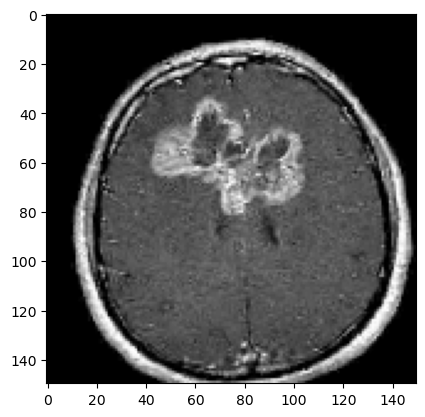

In [17]:
# Plot Input Images
fnames = [os.path.join(train_dir+"/YES", fname) for
    fname in os.listdir(train_dir+"/YES")]

img_path = fnames[0]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [18]:
# Training Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,       
    width_shift_range=0.1,                               
    height_shift_range=0.1, 
    shear_range=0.1, 
    brightness_range=(0.3, 1.0),                 
    horizontal_flip=True,                             
    vertical_flip=True,
    fill_mode='nearest')

In [19]:
# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# Initialize Training Data Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150), 
                                                    batch_size=32, 
                                                    class_mode='binary')

Found 1800 images belonging to 2 classes.


In [21]:
# Initialize Validation Data Generator
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 600 images belonging to 2 classes.


In [22]:
# Train Model With Augmented Data
# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_augmented_data.tf",
        save_best_only=True,
        monitor="val_loss",
        save_format="tf")
]
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/30
57/57 [==============================] - ETA: 0s - loss: 0.8074 - acc: 0.6589INFO:tensorflow:Assets written to: convnet_from_scratch_augmented_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_augmented_data.tf/assets


57/57 [==============================] - 15s 259ms/step - loss: 0.8074 - acc: 0.6589 - val_loss: 0.2484 - val_acc: 0.9067
Epoch 2/30
57/57 [==============================] - 14s 244ms/step - loss: 0.5695 - acc: 0.7200 - val_loss: 0.3381 - val_acc: 0.8250
Epoch 3/30
57/57 [==============================] - 14s 247ms/step - loss: 0.5574 - acc: 0.7167 - val_loss: 0.3145 - val_acc: 0.8417
Epoch 4/30
57/57 [==============================] - 14s 245ms/step - loss: 0.5192 - acc: 0.7572 - val_loss: 0.3291 - val_acc: 0.8417
Epoch 5/30
57/57 [==============================] - 14s 252ms/step - loss: 0.5242 - acc: 0.7517 - val_loss: 0.3371 - val_acc: 0.8400
Epoch 6/30
57/57 [==============================] - 14s 244ms/step - loss: 0.5201 - acc: 0.7522 - val_loss: 0.3423 - val_acc: 0.8233
Epoch 7/30
57/57 [==============================] - 14s 252ms/step - loss: 0.4979 - acc: 0.7617 - val_loss: 0.3611 - val_acc: 0.8783
Epoch 8/30
57/57 [==============================] - 14s 246ms/step - loss: 0.496

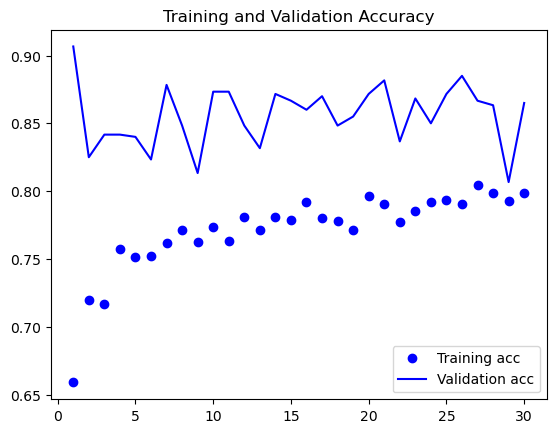

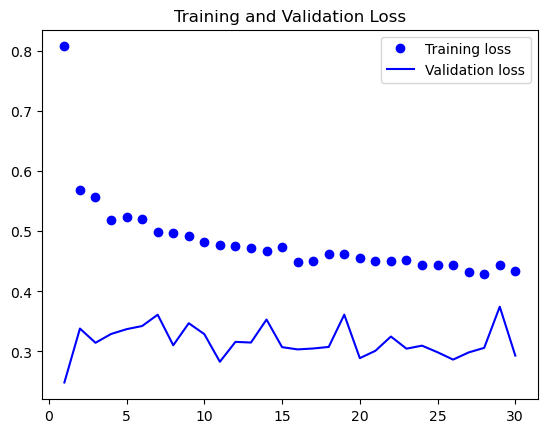

In [23]:
# Inspect Accuracy and Loss
acc_aug = history.history['acc']
val_acc_aug = history.history['val_acc']
loss_aug = history.history['loss']
val_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc) + 1)

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc')
plt.plot(epochs_aug, val_acc_aug, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss')
plt.plot(epochs_aug, val_loss_aug, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [24]:
test_model = keras.models.load_model("convnet_from_scratch_original_data.tf")
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

30/30 [==============================] - 1s 32ms/step - loss: 0.1639 - acc: 0.9600
Test accuracy: 0.960


In [25]:
test_model = keras.models.load_model("convnet_from_scratch_augmented_data.tf")
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

30/30 [==============================] - 1s 33ms/step - loss: 0.2556 - acc: 0.9017
Test accuracy: 0.902


In [26]:
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input


def make_model(learning_rate, droprate, input_shape, inner_layer):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape, input_shape, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(input_shape, input_shape, 3))

    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    dense = keras.layers.Dense(inner_layer, activation='relu')(vectors)
    dropout = keras.layers.Dropout(droprate)(dense)
    outputs = keras.layers.Dense(1, activation="linear")(dropout)

    model = keras.Model(inputs, outputs)
    
    learning_rate = learning_rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.BinaryCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [27]:
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = make_model(learning_rate=lr, droprate=0.0, input_shape=150, inner_layer=25)
    print(lr)
    history = model.fit(train_generator, epochs=10, validation_data=validation_generator, batch_size=32)
    scores[lr] = history.history
    print()
    print()

0.0001
Epoch 1/10
57/57 [==============================] - 55s 914ms/step - loss: 0.6424 - accuracy: 0.5756 - val_loss: 0.4962 - val_accuracy: 0.7450
Epoch 2/10
57/57 [==============================] - 52s 904ms/step - loss: 0.4376 - accuracy: 0.7711 - val_loss: 0.3720 - val_accuracy: 0.8450
Epoch 3/10
57/57 [==============================] - 52s 910ms/step - loss: 0.3530 - accuracy: 0.8439 - val_loss: 0.3135 - val_accuracy: 0.8867
Epoch 4/10
57/57 [==============================] - 52s 911ms/step - loss: 0.3145 - accuracy: 0.8683 - val_loss: 0.2757 - val_accuracy: 0.8933
Epoch 5/10
57/57 [==============================] - 52s 907ms/step - loss: 0.2934 - accuracy: 0.8817 - val_loss: 0.2505 - val_accuracy: 0.9067
Epoch 6/10
57/57 [==============================] - 52s 901ms/step - loss: 0.2586 - accuracy: 0.8967 - val_loss: 0.2384 - val_accuracy: 0.9183
Epoch 7/10
57/57 [==============================] - 52s 904ms/step - loss: 0.2431 - accuracy: 0.9039 - val_loss: 0.2223 - val_accuracy:

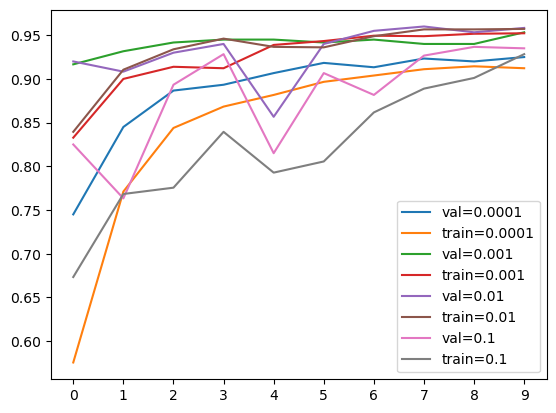

In [28]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' %lr))
    plt.plot(hist['accuracy'], label=('train=%s' %lr))
plt.xticks(np.arange(10))
plt.legend()

In [29]:
scores = {}
learning_rate = 0.01

for size in [10, 25, 100]:
    print(size)
    model = make_model(learning_rate=learning_rate, droprate=0.0, input_shape=150, inner_layer=size)
    print(size)
    history = model.fit(train_generator, epochs=10, validation_data=validation_generator)
    scores[size] = history.history
    print()
    print()

10
10
Epoch 1/10
57/57 [==============================] - 118s 2s/step - loss: 0.3194 - accuracy: 0.8583 - val_loss: 0.2295 - val_accuracy: 0.9300
Epoch 2/10
57/57 [==============================] - 97s 2s/step - loss: 0.2339 - accuracy: 0.9117 - val_loss: 0.1831 - val_accuracy: 0.9367
Epoch 3/10
57/57 [==============================] - 81s 1s/step - loss: 0.2051 - accuracy: 0.9156 - val_loss: 0.2260 - val_accuracy: 0.9033
Epoch 4/10
57/57 [==============================] - 86s 2s/step - loss: 0.1621 - accuracy: 0.9350 - val_loss: 0.1252 - val_accuracy: 0.9450
Epoch 5/10
57/57 [==============================] - 69s 1s/step - loss: 0.1450 - accuracy: 0.9444 - val_loss: 0.1706 - val_accuracy: 0.9417
Epoch 6/10
57/57 [==============================] - 80s 1s/step - loss: 0.1338 - accuracy: 0.9533 - val_loss: 0.1297 - val_accuracy: 0.9367
Epoch 7/10
57/57 [==============================] - 75s 1s/step - loss: 0.1188 - accuracy: 0.9561 - val_loss: 0.1100 - val_accuracy: 0.9567
Epoch 8/10
57

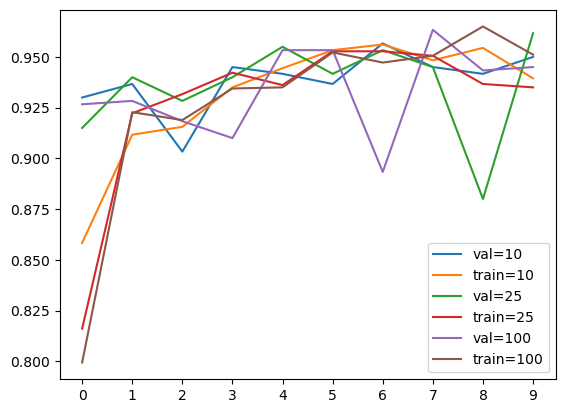

In [30]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' %size))
    plt.plot(hist['accuracy'], label=('train=%s' %size))
plt.xticks(np.arange(10))
plt.legend()

In [31]:
model = make_model(learning_rate=0.01, droprate=0.0, input_shape=150, inner_layer=25)
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
57/57 [==============================] - 104s 2s/step - loss: 0.3665 - accuracy: 0.8406 - val_loss: 0.2002 - val_accuracy: 0.9300
Epoch 2/10
57/57 [==============================] - 97s 2s/step - loss: 0.2015 - accuracy: 0.9211 - val_loss: 0.2044 - val_accuracy: 0.9083
Epoch 3/10
57/57 [==============================] - 98s 2s/step - loss: 0.1784 - accuracy: 0.9294 - val_loss: 0.3045 - val_accuracy: 0.8667
Epoch 4/10
57/57 [==============================] - 96s 2s/step - loss: 0.2035 - accuracy: 0.9133 - val_loss: 0.1629 - val_accuracy: 0.9300
Epoch 5/10
57/57 [==============================] - 61s 1s/step - loss: 0.1581 - accuracy: 0.9300 - val_loss: 0.1153 - val_accuracy: 0.9567
Epoch 6/10
57/57 [==============================] - 100s 2s/step - loss: 0.1089 - accuracy: 0.9517 - val_loss: 0.1517 - val_accuracy: 0.9450
Epoch 7/10
57/57 [==============================] - 96s 2s/step - loss: 0.1183 - accuracy: 0.9589 - val_loss: 0.1122 - val_accuracy: 0.9567
Epoch 8/10
57/57 [

In [32]:
test_model = model
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

30/30 [==============================] - 12s 409ms/step - loss: 0.3021 - accuracy: 0.8967
Test accuracy: 0.897


In [33]:
train_datagen = ImageDataGenerator(rescale=1./255)
# Training Data Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    shuffle=True,
                                                    class_mode='binary')

Found 1800 images belonging to 2 classes.


In [34]:
model = make_model(learning_rate=0.01, droprate=0.0, input_shape=150, inner_layer=25)
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
90/90 [==============================] - 96s 1s/step - loss: 0.3545 - accuracy: 0.8567 - val_loss: 0.2485 - val_accuracy: 0.8750
Epoch 2/10
90/90 [==============================] - 92s 1s/step - loss: 0.1696 - accuracy: 0.9350 - val_loss: 0.1697 - val_accuracy: 0.9283
Epoch 3/10
90/90 [==============================] - 116s 1s/step - loss: 0.1060 - accuracy: 0.9572 - val_loss: 0.1588 - val_accuracy: 0.9317
Epoch 4/10
90/90 [==============================] - 100s 1s/step - loss: 0.1108 - accuracy: 0.9528 - val_loss: 0.1458 - val_accuracy: 0.9517
Epoch 5/10
90/90 [==============================] - 117s 1s/step - loss: 0.0682 - accuracy: 0.9739 - val_loss: 0.1462 - val_accuracy: 0.9483
Epoch 6/10
90/90 [==============================] - 96s 1s/step - loss: 0.0436 - accuracy: 0.9800 - val_loss: 0.1086 - val_accuracy: 0.9617
Epoch 7/10
90/90 [==============================] - 114s 1s/step - loss: 0.0323 - accuracy: 0.9844 - val_loss: 0.1148 - val_accuracy: 0.9617
Epoch 8/10
90/90

In [35]:
test_model = model
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

30/30 [==============================] - 25s 823ms/step - loss: 0.1778 - accuracy: 0.9533
Test accuracy: 0.953


In [36]:
from tensorflow.keras.applications.vgg19 import VGG19


def make_model2(learning_rate, droprate, input_shape, inner_layer):
    base_model = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape, input_shape, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(input_shape, input_shape, 3))

    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    dense1 = keras.layers.Dense(inner_layer, activation='relu')(vectors)
    dense2 = keras.layers.Dense(int(inner_layer*0.5), activation='relu')(dense1)
    dense3 = keras.layers.Dense(int(inner_layer*0.15), activation='relu')(dense2)
    dropout = keras.layers.Dropout(droprate)(dense3)
    outputs = keras.layers.Dense(1, activation="linear")(dropout)

    model = keras.Model(inputs, outputs)
    
    learning_rate = learning_rate
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    loss = keras.losses.BinaryCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [37]:
model2 = make_model2(learning_rate=0.01, droprate=0.0, input_shape=150, inner_layer=25)
history = model2.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
90/90 [==============================] - 245s 3s/step - loss: 0.6808 - accuracy: 0.5011 - val_loss: 0.6667 - val_accuracy: 0.5000
Epoch 2/30
90/90 [==============================] - 247s 3s/step - loss: 0.6603 - accuracy: 0.5122 - val_loss: 0.6513 - val_accuracy: 0.5950
Epoch 3/30
90/90 [==============================] - 248s 3s/step - loss: 0.6443 - accuracy: 0.5572 - val_loss: 0.6300 - val_accuracy: 0.5367
Epoch 4/30
90/90 [==============================] - 278s 3s/step - loss: 0.6205 - accuracy: 0.6250 - val_loss: 0.6012 - val_accuracy: 0.7167
Epoch 5/30
90/90 [==============================] - 213s 2s/step - loss: 0.5875 - accuracy: 0.6861 - val_loss: 0.5619 - val_accuracy: 0.7200
Epoch 6/30
90/90 [==============================] - 245s 3s/step - loss: 0.5484 - accuracy: 0.7228 - val_loss: 0.5181 - val_accuracy: 0.7717
Epoch 7/30
90/90 [==============================] - 231s 3s/step - loss: 0.5068 - accuracy: 0.7367 - val_loss: 0.5323 - val_accuracy: 0.6217
Epoch 8/30
90

In [38]:
test_model = model2
test_loss, test_acc = test_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.3f}")

30/30 [==============================] - 37s 1s/step - loss: 0.2876 - accuracy: 0.8683
Test accuracy: 0.868


In [40]:
import tensorflow as tf
Loaded_Model = tf.keras.models.load_model('convnet_from_scratch_original_data.tf')

In [41]:
tf.keras.models.save_model(Loaded_Model, 'convnet_from_scratch_original_data.h5') # Saving the Model in H5 Format

/tmp/ipykernel_41191/3237619043.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(Loaded_Model, 'convnet_from_scratch_original_data.h5') # Saving the Model in H5 Format


In [42]:
Loaded_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11215873 (42.79 MB)
Trainable params: 11215873 (42.79 MB)
Non-trainable params: 0 (0.00 Byte)
______________